# BUSINESS PROBLEM

Entender as principais características/comportamento de um cliente que podem levar a Churn (não voltar a comprar na plataforma). A solução proposta poderá ser utilizada para atuar sobre esses clientes com promoções, descontos ou melhorias na plataforma.

Como a frequência de compras dos clientes do IFood é relativamente alta, o modelo será construído usando features construídas em um período fechado de 1 mês. A métrica principal de avaliação do modelo é a AUC.

# IMPORTANDO DADOS E BIBLIOTECAS

In [125]:
# importar os pacotes necessários
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# importar algoritmos e metricas
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from scipy.stats import ks_2samp
from sklearn import metrics
from statsmodels.stats.outliers_influence import variance_inflation_factor

from lightgbm import LGBMClassifier

from sklearn.pipeline import Pipeline

from matplotlib.legend_handler import HandlerLine2D

# filtrar mensagens de warning
import warnings
warnings.filterwarnings('ignore')

In [127]:
db = pd.read_csv('df_orders.csv', sep=',')

In [128]:
print(db.head().to_string())

                               order_id  order_number     order_timestamp_local     order_shift    last_status_date_local  order_total  credit  paid_amount delivery_type  scheduled scheduled_creation_date_local    device_app_version device_type device_platform payment_method customer_state_label customer_city           customer_district customer_centroid_id customer_has_plus customer_seg_status_last_month  customer_seg_recency_bucket  customer_seg_frequency_bucket  customer_seg_merchant_offer_bucket customer_seg_benefits_sensitivity_bucket customer_seg_marlin_tag  customer_seg_gross_income_bucket customer_seg_preferred_shift  frn_id merchant_city      merchant_district merchant_centroid_id merchant_dish_type  distance_merchant_customer  promo_is_promotion  normal_items_quantity  promo_items_quantity  order_lag_at_login  order_lead_at_login          order_date_local  valid_order                            session_id                                                       customer_id
0  63

In [129]:
print(80*'*')
print(f'Dimensões: {db.shape[0]} linhas e {db.shape[1]} colunas.\n')
print(80*'*')
print('Tipos:', '\n\n'+str(db.dtypes)+'\n')
print(80*'*')
print('Quantidade de valores únicos: ', '\n\n'+str(db.nunique()))
print('\n'+80*'*')
print('Prévia dos valores: \n')
for col in db.columns.values:
  if len(db[col].unique()) > 5:
    print('\n'+col+': ', db[col].unique()[:5], 'entre outros...')
  else:
    print('\n'+col+': ', db[col].unique())

********************************************************************************
Dimensões: 492138 linhas e 43 colunas.

********************************************************************************
Tipos: 

order_id                                     object
order_number                                  int64
order_timestamp_local                        object
order_shift                                  object
last_status_date_local                       object
order_total                                 float64
credit                                      float64
paid_amount                                 float64
delivery_type                                object
scheduled                                      bool
scheduled_creation_date_local                object
device_app_version                           object
device_type                                  object
device_platform                              object
payment_method                               object
customer_

In [130]:
db.agg({'order_timestamp_local': ['min', 'max']})

,order_timestamp_local
min,2019-06-01T00:00:15.369Z
max,2019-12-31T23:31:59.972Z


# SUMÁRIO


O dataset possui 492138 linhas e 43 colunas.

Cada linha representa um pedido realizado pelos clientes, sendo no total 30.079 clientes distintos. A relaçao de cliente x pedido é de 1 para N.

O pedido mais antigo se inicia em 01/06/2019 e o mais recente termina em 31/12/2019.


Features associadas ao PEDIDO:

`['order_id:  'order_number', 'order_shift', 'last_status_date_local', 'order_total', 'credit', 'paid_amount' ,'delivery_type', 'scheduled', 'scheduled_creation_date_local', 'device_app_version', 'device_type', 'device_platform', 'payment_method', 'distance_merchant_customer', 'promo_is_promotion', 'normal_items_quantity', 'promo_items_quantity', 'order_lag_at_login', 'order_lead_at_login', 'order_date_local','valid_order']`

Features associadas ao CLIENTE:

`['customer_state_label', 'customer_city', 'customer_district', 'customer_centroid_id', 'customer_has_plus', 'customer_seg_status_last_month', 'customer_seg_recency_bucket', 'customer_seg_frequency_bucket', 'customer_seg_merchant_offer_bucket', 'customer_seg_benefits_sensitivity_bucket', 'customer_seg_marlin_tag', 'customer_seg_gross_income_bucket', '
customer_seg_preferred_shift', 'customer_id']`

Features associadas ao VENDEDOR:

`['merchant_city', 'merchant_district', 'merchant_centroid_id', 'merchant_dish_type', 'distance_merchant_customer', ]`

Outros não identificados:

`['session_id', 'frn_id']`

In [131]:
df = db.copy()

# CRIANDO AS AMOSTRAS

O objetivo deste estudo é identificar as chances de churn de um cliente, criaremos a amostra agrupando os dados.

Criaremos features que descrevam o comportamento do cliente com base em 1 mês e usaremos essas variáveis para prever se o cliente irá comprar no próximo mês.

Desconsideraremos as variáveis de segmentação de clientes `customer_seg_...` considerando que não possuímos conhecimento sobre sua origem e significado.

In [132]:
dict_safra_treino = {
    '7':{'feature': {'init':'"2019-06-01"', 'end': '"2019-07-01"'}, 'target': {'init':'"2019-07-01"', 'end': '"2019-08-01"'}},
    '8':{'feature': {'init':'"2019-07-01"', 'end': '"2019-08-01"'}, 'target': {'init':'"2019-08-01"', 'end': '"2019-09-01"'}},
    '9':{'feature': {'init':'"2019-08-01"', 'end': '"2019-09-01"'}, 'target': {'init':'"2019-09-01"', 'end': '"2019-10-01"'}},
    '10':{'feature': {'init':'"2019-09-01"', 'end': '"2019-10-01"'}, 'target': {'init':'"2019-10-01"', 'end': '"2019-11-01"'}},
    '11':{'feature': {'init':'"2019-10-01"', 'end': '"2019-11-01"'}, 'target': {'init':'"2019-11-01"', 'end': '"2019-12-01"'}}
              }

dict_safra_oot = {
    '8':{'feature': {'init':'"2019-07-01"', 'end': '"2019-08-01"'}, 'target': {'init':'"2019-08-01"', 'end': '"2019-09-01"'}},
    '9':{'feature': {'init':'"2019-08-01"', 'end': '"2019-09-01"'}, 'target': {'init':'"2019-09-01"', 'end': '"2019-10-01"'}},
    '10':{'feature': {'init':'"2019-09-01"', 'end': '"2019-10-01"'}, 'target': {'init':'"2019-10-01"', 'end': '"2019-11-01"'}},
    '11':{'feature': {'init':'"2019-10-01"', 'end': '"2019-11-01"'}, 'target': {'init':'"2019-11-01"', 'end': '"2019-12-01"'}},
    '12':{'feature': {'init':'"2019-11-01"', 'end': '"2019-12-01"'}, 'target': {'init':'"2019-12-01"', 'end': '"2020-01-01"'}}
              }

In [133]:
def create_sample_month(df, dict_month):

  df_customer = (
    df
    .query('order_timestamp_local >= '+dict_month['feature']['init']+' & order_timestamp_local < '+dict_month['feature']['end'])
    .groupby('customer_id')
    .agg(soma_receita_1m = ('paid_amount', 'sum'),
         media_valor_pedido = ('order_total', 'mean'),
         media_credito_existente = ('credit', 'mean'),
         qtd_pedidos_1m = ('order_id', 'count'),
         moda_order_shift = ('order_shift', lambda x: x.value_counts(dropna=False).index[0]),
         media_distancia_loja = ('distance_merchant_customer', 'mean'),
         media_qtd_item_normal = ('normal_items_quantity', 'mean'),
         media_qtd_item_promo = ('promo_items_quantity', 'mean'),
         moda_promo_is_promotion = ('promo_is_promotion', lambda x: x.value_counts(dropna=False).index[0]),
         moda_delivery_type = ('delivery_type', lambda x: x.value_counts(dropna=False).index[0]),
         moda_payment_method = ('payment_method', lambda x: x.value_counts(dropna=False).index[0]),
         moda_merchant_dish_type = ('merchant_dish_type', lambda x: x.value_counts(dropna=False).index[0]),
         moda_scheduled = ('scheduled', lambda x: x.value_counts(dropna=False).index[0]),
         moda_customer_has_plus = ('customer_has_plus', lambda x: x.value_counts(dropna=False).index[0]),
         moda_device_platform = ('device_platform', lambda x: x.value_counts(dropna=False).index[0]),
         media_order_lag_at_login = ('order_lag_at_login', 'mean'),
         media_order_lead_at_login = ('order_lead_at_login', 'mean'))
    .assign(data_ref  = lambda df: pd.to_datetime(dict_month['feature']['end'].replace('"',''),utc=True))
    .assign(mes_ref  = lambda df: pd.to_datetime(dict_month['feature']['end'].replace('"',''),utc=True).month)
    .reset_index())

  df_target  = df.copy()

  df_target  = (
      df_target
      .query('order_timestamp_local >= '+dict_month['target']['init']+' & order_timestamp_local < '+dict_month['target']['end'])
      .filter(['customer_id'])
      .drop_duplicates()
  )

  df_abt = (
          df_customer
          .merge(df_target, on='customer_id', how='left', indicator=True)
          .assign(churn_next_month = lambda df: np.where(df['_merge'] == "left_only", 1, 0))
          .drop(columns='_merge')
  )

  return df_abt

## ABT

In [134]:
df_abt_7 = create_sample_month(df, dict_safra_treino['7'])
df_abt_8 = create_sample_month(df, dict_safra_treino['8'])
df_abt_9 = create_sample_month(df, dict_safra_treino['9'])
df_abt_10 = create_sample_month(df, dict_safra_treino['10'])
df_abt_11 = create_sample_month(df, dict_safra_treino['11'])

list_abts = [df_abt_7, df_abt_8, df_abt_9, df_abt_10, df_abt_11]

## OOT

In [135]:
df_oot_8 = create_sample_month(df, dict_safra_oot['8'])
df_oot_9 = create_sample_month(df, dict_safra_oot['9'])
df_oot_10 = create_sample_month(df, dict_safra_oot['10'])
df_oot_11 = create_sample_month(df, dict_safra_oot['11'])
df_oot_12 = create_sample_month(df, dict_safra_oot['12'])

list_oots = [df_oot_8, df_oot_9, df_oot_10, df_oot_11, df_oot_12]

# MISSING E NULOS


A flag que indica se o cliente possui o programa "plus" `customer_has_plus` possui marcações a partir do mês 9, vamos retirar esta variável para equalizar as amostras mais antigas. Excluiremos também valores nulos na feature `media_order_lead_at_login` impactando cerca de 5% da amostra total e `media_order_lag_at_login` que impacta a primeira amostra em 12%.

In [136]:
i=0
for data in list_abts:
  nulls = data.isnull().sum()/data.shape[0]
  if i == 0:
    df_nulls = nulls.sort_values(ascending=False)
  else:
    df_nulls = pd.concat([df_nulls, nulls], axis = 1)

  i+= 1

df_nulls.head(10)

,0,1,0,0,0
moda_customer_has_plus,1.000000,1.000000,1.000000,0.996855,0.000060
media_order_lag_at_login,0.123807,0.000000,0.000000,0.000000,0.000000
media_order_lead_at_login,0.112703,0.033241,0.033893,0.034949,0.044054
customer_id,0.000000,0.000000,0.000000,0.000000,0.000000
moda_payment_method,0.000000,0.000000,0.000000,0.000000,0.000000
mes_ref,0.000000,0.000000,0.000000,0.000000,0.000000
data_ref,0.000000,0.000000,0.000000,0.000000,0.000000
moda_device_platform,0.000000,0.000000,0.000000,0.000000,0.000000
moda_scheduled,0.000000,0.000000,0.000000,0.000000,0.000000
moda_merchant_dish_type,0.000000,0.000000,0.000000,0.000000,0.000000


In [137]:
i=0
for data in list_oots:
  nulls = data.isnull().sum()/data.shape[0]
  if i == 0:
    df_nulls = nulls.sort_values(ascending=False)
  else:
    df_nulls = pd.concat([df_nulls, nulls], axis = 1)

  i+= 1

df_nulls.head(10)

,0,1,0,0,0
moda_customer_has_plus,1.000000,1.000000,0.996855,0.000060,0.000000
media_order_lead_at_login,0.033241,0.033893,0.034949,0.044054,0.059434
customer_id,0.000000,0.000000,0.000000,0.000000,0.000000
moda_payment_method,0.000000,0.000000,0.000000,0.000000,0.000000
mes_ref,0.000000,0.000000,0.000000,0.000000,0.000000
data_ref,0.000000,0.000000,0.000000,0.000000,0.000000
media_order_lag_at_login,0.000000,0.000000,0.000000,0.000000,0.000000
moda_device_platform,0.000000,0.000000,0.000000,0.000000,0.000000
moda_scheduled,0.000000,0.000000,0.000000,0.000000,0.000000
moda_merchant_dish_type,0.000000,0.000000,0.000000,0.000000,0.000000


In [138]:
df[df['customer_has_plus'].isna() == False].agg({'order_timestamp_local': ['min', 'max']})

,order_timestamp_local
min,2019-09-30T20:13:44.716Z
max,2019-12-31T23:31:59.972Z


In [139]:
list_clean_abts = []
for data in list_abts:
  data = data.drop(['moda_customer_has_plus'], axis=1)
  data = data.dropna().reset_index()
  list_clean_abts.append(data)

list_clean_oots = []
for data in list_oots:
  data = data.drop(['moda_customer_has_plus'], axis=1)
  data = data.dropna().reset_index()
  list_clean_oots.append(data)

# ESTATÍSTICA DESCRITIVA

In [140]:
i=0
for data in list_clean_abts:
  temp = data['churn_next_month'].value_counts()
  if i == 0:
    df_temp = temp
  else:
    df_temp = pd.concat([df_temp, temp], axis = 1)

  i+= 1

df_temp

,churn_next_month,churn_next_month,churn_next_month,churn_next_month,churn_next_month
0,17673,14007,13506,13304,13376
1,7314,3821,3226,2960,2508


In [141]:
i=0
for data in list_clean_abts:
  temp = data['churn_next_month'].value_counts(normalize=True)
  if i == 0:
    df_temp = temp
  else:
    df_temp = pd.concat([df_temp, temp], axis = 1)

  i+= 1

df_temp

,churn_next_month,churn_next_month,churn_next_month,churn_next_month,churn_next_month
0,0.707288,0.785674,0.807196,0.818003,0.842105
1,0.292712,0.214326,0.192804,0.181997,0.157895


In [142]:
i=0
for data in list_clean_oots:
  temp = data['churn_next_month'].value_counts()
  if i == 0:
    df_temp = temp
  else:
    df_temp = pd.concat([df_temp, temp], axis = 1)

  i+= 1

df_temp

,churn_next_month,churn_next_month,churn_next_month,churn_next_month,churn_next_month
0,14007,13506,13304,13376,13347
1,3821,3226,2960,2508,2431


In [143]:
i=0
for data in list_clean_oots:
  temp = data['churn_next_month'].value_counts(normalize=True)
  if i == 0:
    df_temp = temp
  else:
    df_temp = pd.concat([df_temp, temp], axis = 1)

  i+= 1

df_temp

,churn_next_month,churn_next_month,churn_next_month,churn_next_month,churn_next_month
0,0.785674,0.807196,0.818003,0.842105,0.845925
1,0.214326,0.192804,0.181997,0.157895,0.154075


## NUMÉRICAS

In [144]:
i=0
for data in list_clean_abts:
  if i == 0:
    df_abt = data
  else:
    df_abt = pd.concat([df_abt, data], axis = 0)

  i+= 1

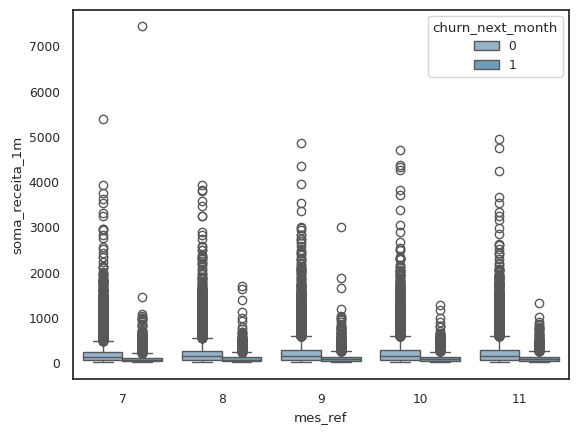

In [145]:
sns.boxplot(data=df_abt, x='mes_ref', y='soma_receita_1m', hue='churn_next_month')
plt.show()

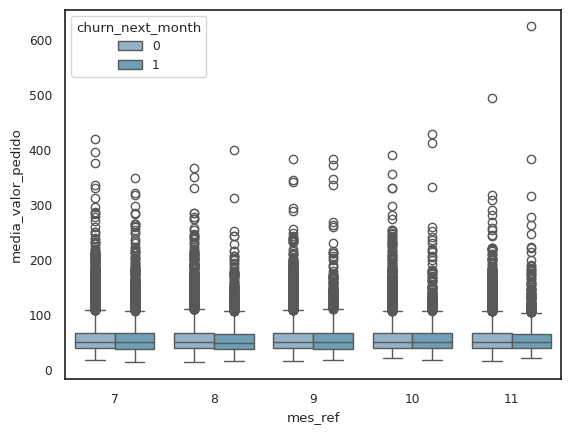

In [146]:
sns.boxplot(data=df_abt, x='mes_ref', y='media_valor_pedido', hue='churn_next_month')
plt.show()

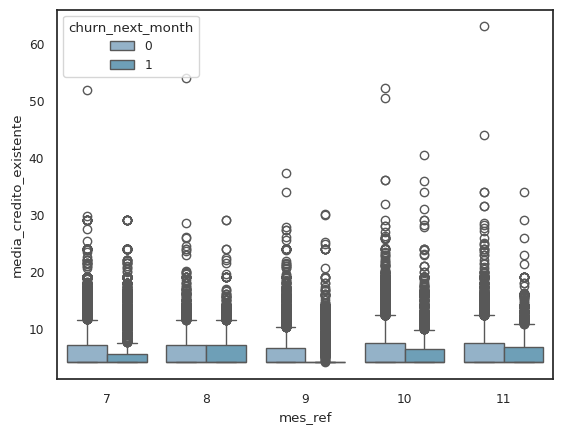

In [147]:
sns.boxplot(data=df_abt, x='mes_ref',y='media_credito_existente', hue='churn_next_month')

plt.show()

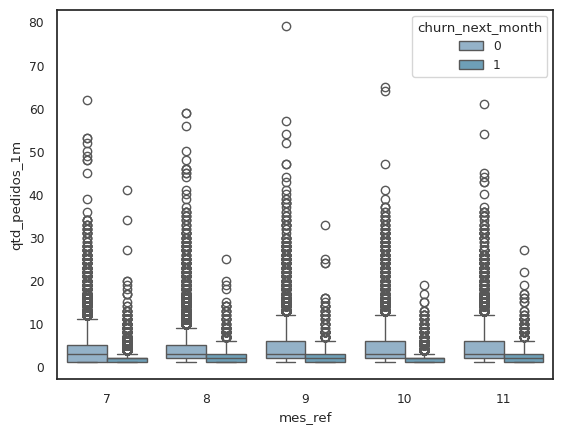

In [148]:
sns.boxplot(data=df_abt, x='mes_ref',y='qtd_pedidos_1m', hue='churn_next_month')
plt.show()

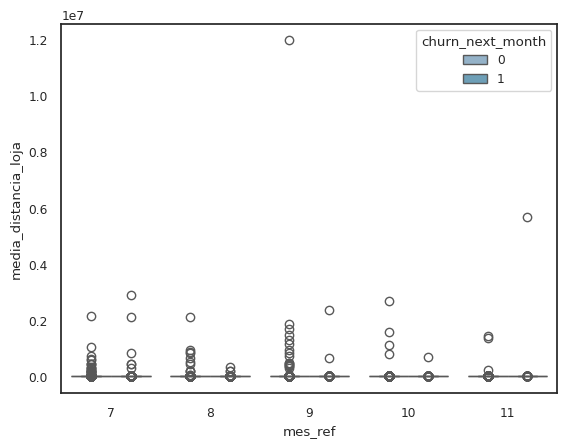

In [149]:
sns.boxplot(data=df_abt, x='mes_ref',y='media_distancia_loja', hue='churn_next_month')
plt.show()

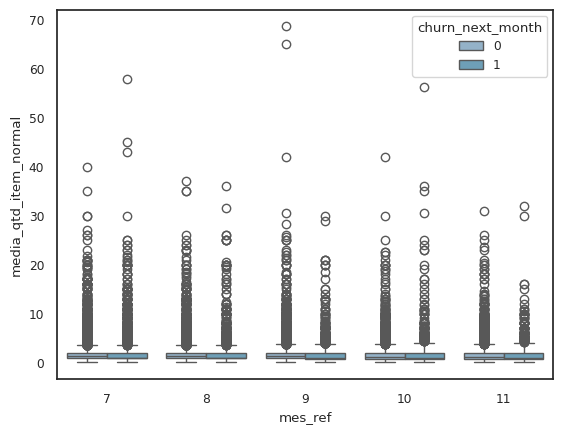

In [150]:
sns.boxplot(data=df_abt, x='mes_ref', y='media_qtd_item_normal', hue='churn_next_month')
plt.show()

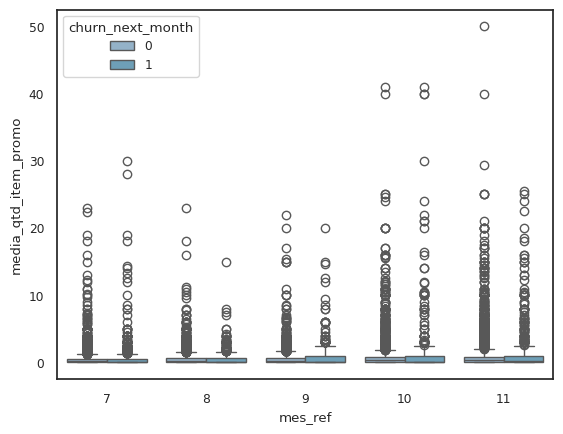

In [151]:
sns.boxplot(data=df_abt, x='mes_ref', y='media_qtd_item_promo', hue='churn_next_month')
plt.show()

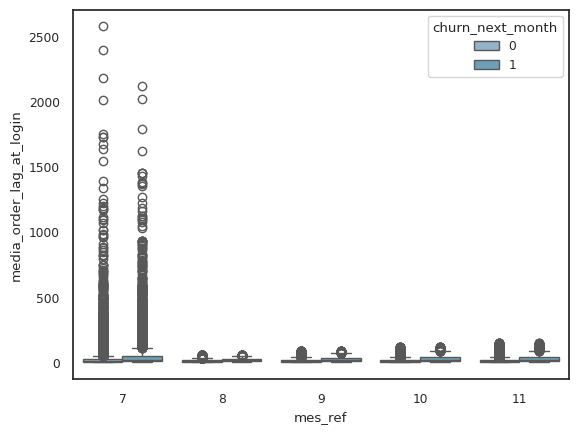

In [152]:
sns.boxplot(data=df_abt, x='mes_ref', y='media_order_lag_at_login', hue='churn_next_month')
plt.show()

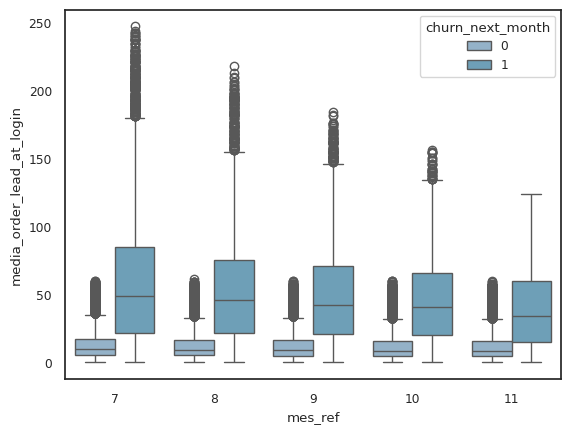

In [153]:
sns.boxplot(data=df_abt, x='mes_ref', y='media_order_lead_at_login', hue='churn_next_month')
plt.show()

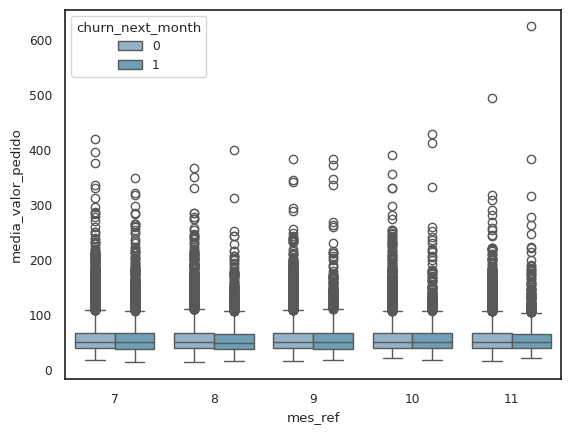

In [154]:
sns.boxplot(data=df_abt, x='mes_ref', y='media_valor_pedido', hue='churn_next_month')
plt.show()

## CATEGÓRICAS

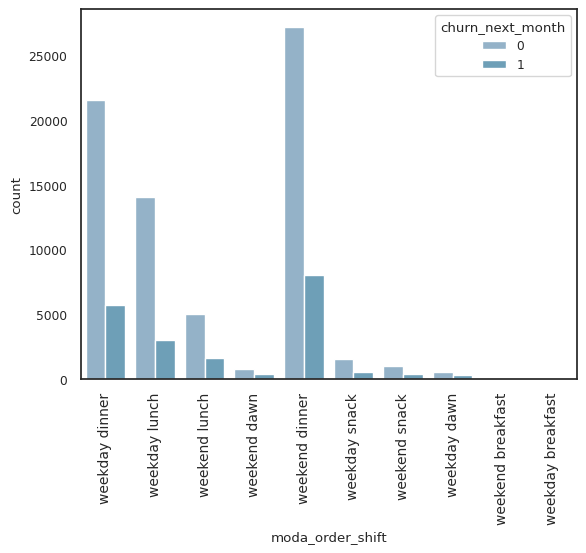

In [155]:
sns.countplot(data=df_abt, x='moda_order_shift', hue='churn_next_month')
plt.xticks(rotation=90, fontsize=10)
plt.show()

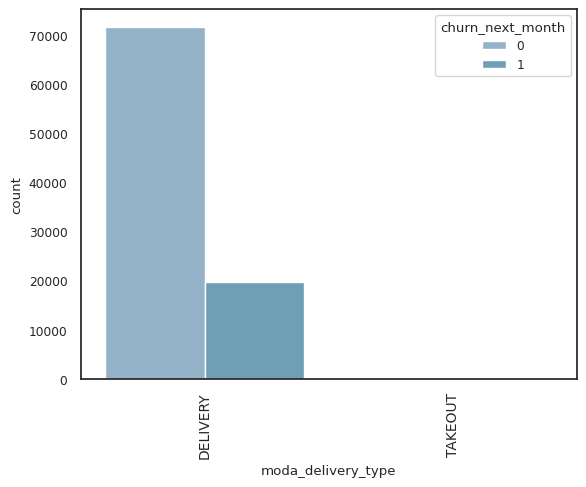

In [156]:
sns.countplot(data=df_abt, x='moda_delivery_type', hue='churn_next_month')
plt.xticks(rotation=90, fontsize=10)
plt.show()

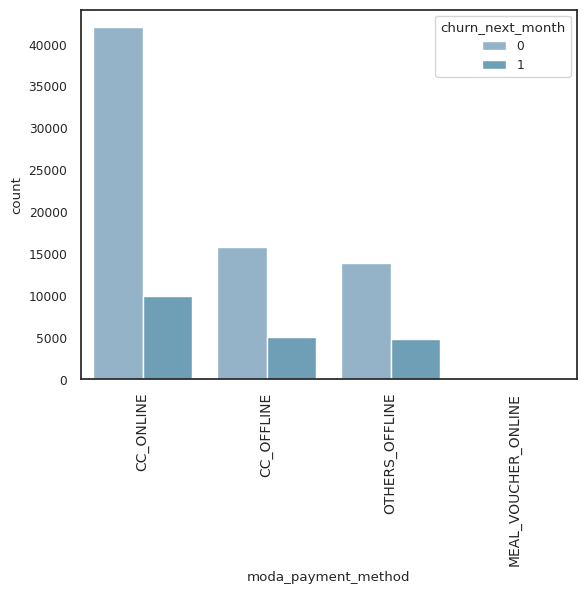

In [157]:
sns.countplot(data=df_abt, x='moda_payment_method', hue='churn_next_month')
plt.xticks(rotation=90, fontsize=10)
plt.show()

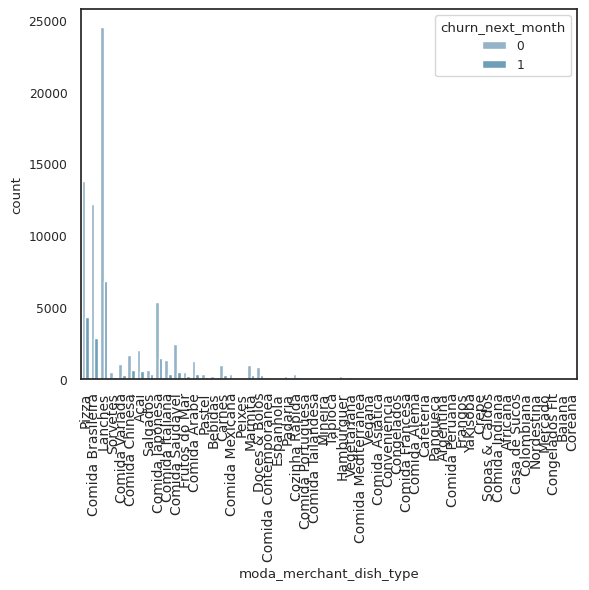

In [158]:
sns.countplot(data=df_abt, x='moda_merchant_dish_type', hue='churn_next_month')
plt.xticks(rotation=90, fontsize=10)
plt.show()

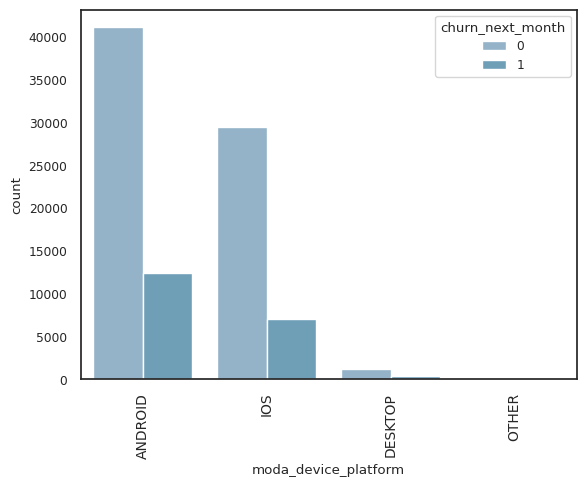

In [159]:
sns.countplot(data=df_abt, x='moda_device_platform', hue='churn_next_month')
plt.xticks(rotation=90, fontsize=10)
plt.show()

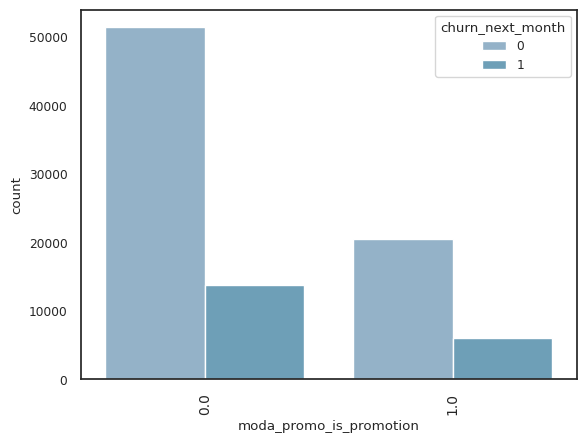

In [160]:
sns.countplot(data=df_abt, x='moda_promo_is_promotion', hue='churn_next_month')
plt.xticks(rotation=90, fontsize=10)
plt.show()

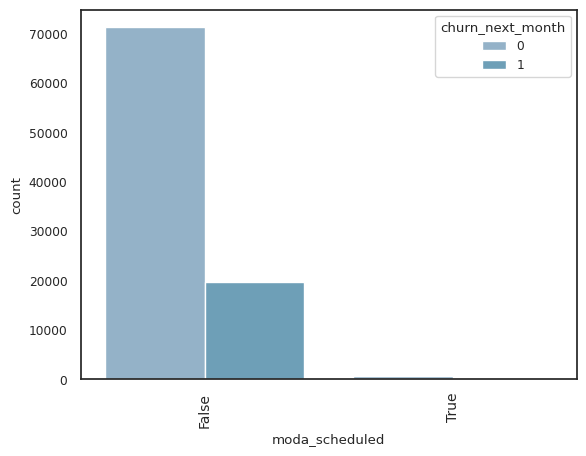

In [161]:
sns.countplot(data=df_abt, x='moda_scheduled', hue='churn_next_month')
plt.xticks(rotation=90, fontsize=10)
plt.show()

# CATEGORIZANDO FEATURES

In [162]:
lbl_y = 'churn_next_month'
valid_cols = list(df_abt.drop(['index','data_ref', 'mes_ref', 'customer_id'], axis=1).columns)

In [163]:
valid_cols

['soma_receita_1m',
 'media_valor_pedido',
 'media_credito_existente',
 'qtd_pedidos_1m',
 'moda_order_shift',
 'media_distancia_loja',
 'media_qtd_item_normal',
 'media_qtd_item_promo',
 'moda_promo_is_promotion',
 'moda_delivery_type',
 'moda_payment_method',
 'moda_merchant_dish_type',
 'moda_scheduled',
 'moda_device_platform',
 'media_order_lag_at_login',
 'media_order_lead_at_login',
 'churn_next_month']

In [164]:
#numerica porém com sinais de que é catgorica
num_but_cat = [col for col in valid_cols if df_abt[col].nunique() < 10 and df_abt[col].dtypes not in ["O", "bool"] and col != lbl_y]
num_but_cat

['moda_promo_is_promotion']

In [165]:
num_var = [col for col in valid_cols if df_abt[col].dtypes not in ["O","bool"] and col not in num_but_cat and col != lbl_y]
num_var

['soma_receita_1m',
 'media_valor_pedido',
 'media_credito_existente',
 'qtd_pedidos_1m',
 'media_distancia_loja',
 'media_qtd_item_normal',
 'media_qtd_item_promo',
 'media_order_lag_at_login',
 'media_order_lead_at_login']

In [166]:
cat_var = [col for col in valid_cols if df_abt[col].dtypes in ["O","bool"] and col not in num_but_cat and col != lbl_y]
cat_var

['moda_order_shift',
 'moda_delivery_type',
 'moda_payment_method',
 'moda_merchant_dish_type',
 'moda_scheduled',
 'moda_device_platform']

In [167]:
#categorica com cardinalidade
cat_but_car = [col for col in valid_cols if df_abt[col].nunique() > 20 and df_abt[col].dtypes == "O" and  col != lbl_y]
cat_but_car

['moda_merchant_dish_type']

# PADRONIZANDO DADOS

In [168]:
list_encoded_abts = []

for data in list_clean_abts:

  encoded_df_train = data[valid_cols].copy()

  # normalizar as colunas numéricas
  encoded_df_train[num_var] = StandardScaler().fit_transform(encoded_df_train[num_var].values)

  # Dummies para categoricas
  dummies = pd.get_dummies(encoded_df_train[cat_var].astype(str))
  encoded_df_train = pd.concat([encoded_df_train, dummies], axis = 1)

  # Dummies para numericas porem com sinais de categorica.
  dummies = pd.get_dummies(encoded_df_train[num_but_cat].astype(str))
  encoded_df_train = pd.concat([encoded_df_train, dummies], axis = 1)

  # Label encoding para categorica com cardinalidade
  for col in cat_but_car:
    encoded_df_train[col] = LabelEncoder().fit_transform(encoded_df_train[col])

  #Removendo colunas pré transformação.
  drop_cols = cat_var + num_but_cat
  encoded_df_train = encoded_df_train.drop(drop_cols, axis=1)

  list_encoded_abts.append(encoded_df_train)

In [169]:
list_encoded_oots = []

for data in list_clean_oots:

  encoded_df_oot = data[valid_cols].copy()

  # normalizar as colunas numéricas
  encoded_df_oot[num_var] = StandardScaler().fit_transform(encoded_df_oot[num_var].values)

  # Dummies para categoricas
  dummies = pd.get_dummies(encoded_df_oot[cat_var].astype(str))
  encoded_df_oot = pd.concat([encoded_df_oot, dummies], axis = 1)

  # Dummies para numericas porem com sinais de categorica.
  dummies = pd.get_dummies(encoded_df_oot[num_but_cat].astype(str))
  encoded_df_oot = pd.concat([encoded_df_oot, dummies], axis = 1)

  # Label encoding para categorica com cardinalidade
  for col in cat_but_car:
    encoded_df_oot[col] = LabelEncoder().fit_transform(encoded_df_oot[col])

  #Removendo colunas pré transformação.
  drop_cols = cat_var + num_but_cat
  encoded_df_oot = encoded_df_oot.drop(drop_cols, axis=1)

  list_encoded_oots.append(encoded_df_oot)

# VIF e IV

In [170]:
def show_VIF(df, feature_cols):
  # the independent variables set
  X = df[feature_cols].copy()
  X['intercept'] = 1

  # VIF dataframe
  vif_data = pd.DataFrame()
  vif_data["feature"] = X.columns

  # calculating VIF for each feature
  vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]

  vif_data = vif_data.sort_values(by='VIF', ascending=False)

  print("\n", vif_data)

In [171]:
for data in list_encoded_abts:
  show_VIF(data, num_var)


                      feature       VIF
0            soma_receita_1m  5.047731
3             qtd_pedidos_1m  4.585829
1         media_valor_pedido  1.752260
8  media_order_lead_at_login  1.191410
5      media_qtd_item_normal  1.108588
7   media_order_lag_at_login  1.072151
2    media_credito_existente  1.056630
6       media_qtd_item_promo  1.037523
4       media_distancia_loja  1.000615
9                  intercept  1.000000

                      feature       VIF
0            soma_receita_1m  5.610434
3             qtd_pedidos_1m  5.347301
1         media_valor_pedido  1.877077
7   media_order_lag_at_login  1.450598
8  media_order_lead_at_login  1.241801
5      media_qtd_item_normal  1.146098
2    media_credito_existente  1.084000
6       media_qtd_item_promo  1.050760
4       media_distancia_loja  1.000187
9                  intercept  1.000000

                      feature       VIF
0            soma_receita_1m  5.719190
3             qtd_pedidos_1m  5.281947
1         media_val

In [172]:
def iv_woe(data, target, bins=10, show_woe=False):

    #Empty Dataframe
    newDF,woeDF = pd.DataFrame(), pd.DataFrame()

    #Extract Column Names
    cols = data.columns

    #Run WOE and IV on all the independent variables
    for ivars in cols[~cols.isin([target])]:
        if (data[ivars].dtype.kind in 'bifc') and (len(np.unique(data[ivars]))>10):
            binned_x = pd.qcut(data[ivars], bins,  duplicates='drop')
            d0 = pd.DataFrame({'x': binned_x, 'y': data[target]})
        else:
            d0 = pd.DataFrame({'x': data[ivars], 'y': data[target]})
        d0 = d0.astype({"x": str})
        d = d0.groupby("x", as_index=False, dropna=False).agg({"y": ["count", "sum"]})

        d.columns = ['Cutoff', 'N', 'Events']
        d['% of Events'] = np.maximum(d['Events'], 0.5) / d['Events'].sum()
        d['Non-Events'] = d['N'] - d['Events']
        d['% of Non-Events'] = np.maximum(d['Non-Events'], 0.5) / d['Non-Events'].sum()
        d['WoE'] = np.log(d['% of Non-Events']/d['% of Events'])
        d['IV'] = d['WoE'] * (d['% of Non-Events']-d['% of Events'])
        d.insert(loc=0, column='Variable', value=ivars)
        #print("Information value of " + ivars + " is " + str(round(d['IV'].sum(),6)))

        temp =pd.DataFrame({"Variable" : [ivars], "IV" : [round(d['IV'].sum(), 4)]}, columns = ["Variable", "IV"])
        newDF=pd.concat([newDF,temp], axis=0)
        woeDF=pd.concat([woeDF,d], axis=0)

    newDF['Level'] = 'Very Weak'
    newDF.loc[(newDF['IV'] > 0.02) & (newDF['IV'] < 0.1), 'Level'] = 'Weak'
    newDF.loc[(newDF['IV'] > 0.1) & (newDF['IV'] < 0.3), 'Level'] = 'Average'
    newDF.loc[(newDF['IV'] > 0.3) & (newDF['IV'] < 0.5), 'Level'] = 'Strong'
    newDF.loc[(newDF['IV'] > 0.5), 'Level'] = 'Suspicious'
    newDF = newDF.sort_values(by='IV', ascending=False)
    #Show WOE Table
    if show_woe == True:
        print("\n", newDF.head(30).to_string())

    return newDF, woeDF

In [173]:
for data in list_encoded_abts:
  newDF, woeDF = iv_woe(data, lbl_y, bins=100, show_woe=True)


                                     Variable      IV       Level
0                  media_order_lead_at_login  4.3229  Suspicious
0                             qtd_pedidos_1m  0.5891  Suspicious
0                            soma_receita_1m  0.5208  Suspicious
0                   media_order_lag_at_login  0.4483      Strong
0                      media_qtd_item_normal  0.2676     Average
0                       media_qtd_item_promo  0.2251     Average
0                    media_credito_existente  0.1606     Average
0                       media_distancia_loja  0.0495        Weak
0                         media_valor_pedido  0.0436        Weak
0              moda_payment_method_CC_ONLINE  0.0250        Weak
0             moda_order_shift_weekday lunch  0.0146   Very Weak
0                   moda_device_platform_IOS  0.0107   Very Weak
0               moda_device_platform_ANDROID  0.0098   Very Weak
0             moda_payment_method_CC_OFFLINE  0.0088   Very Weak
0         moda_payment_

# CORRELAÇÃO

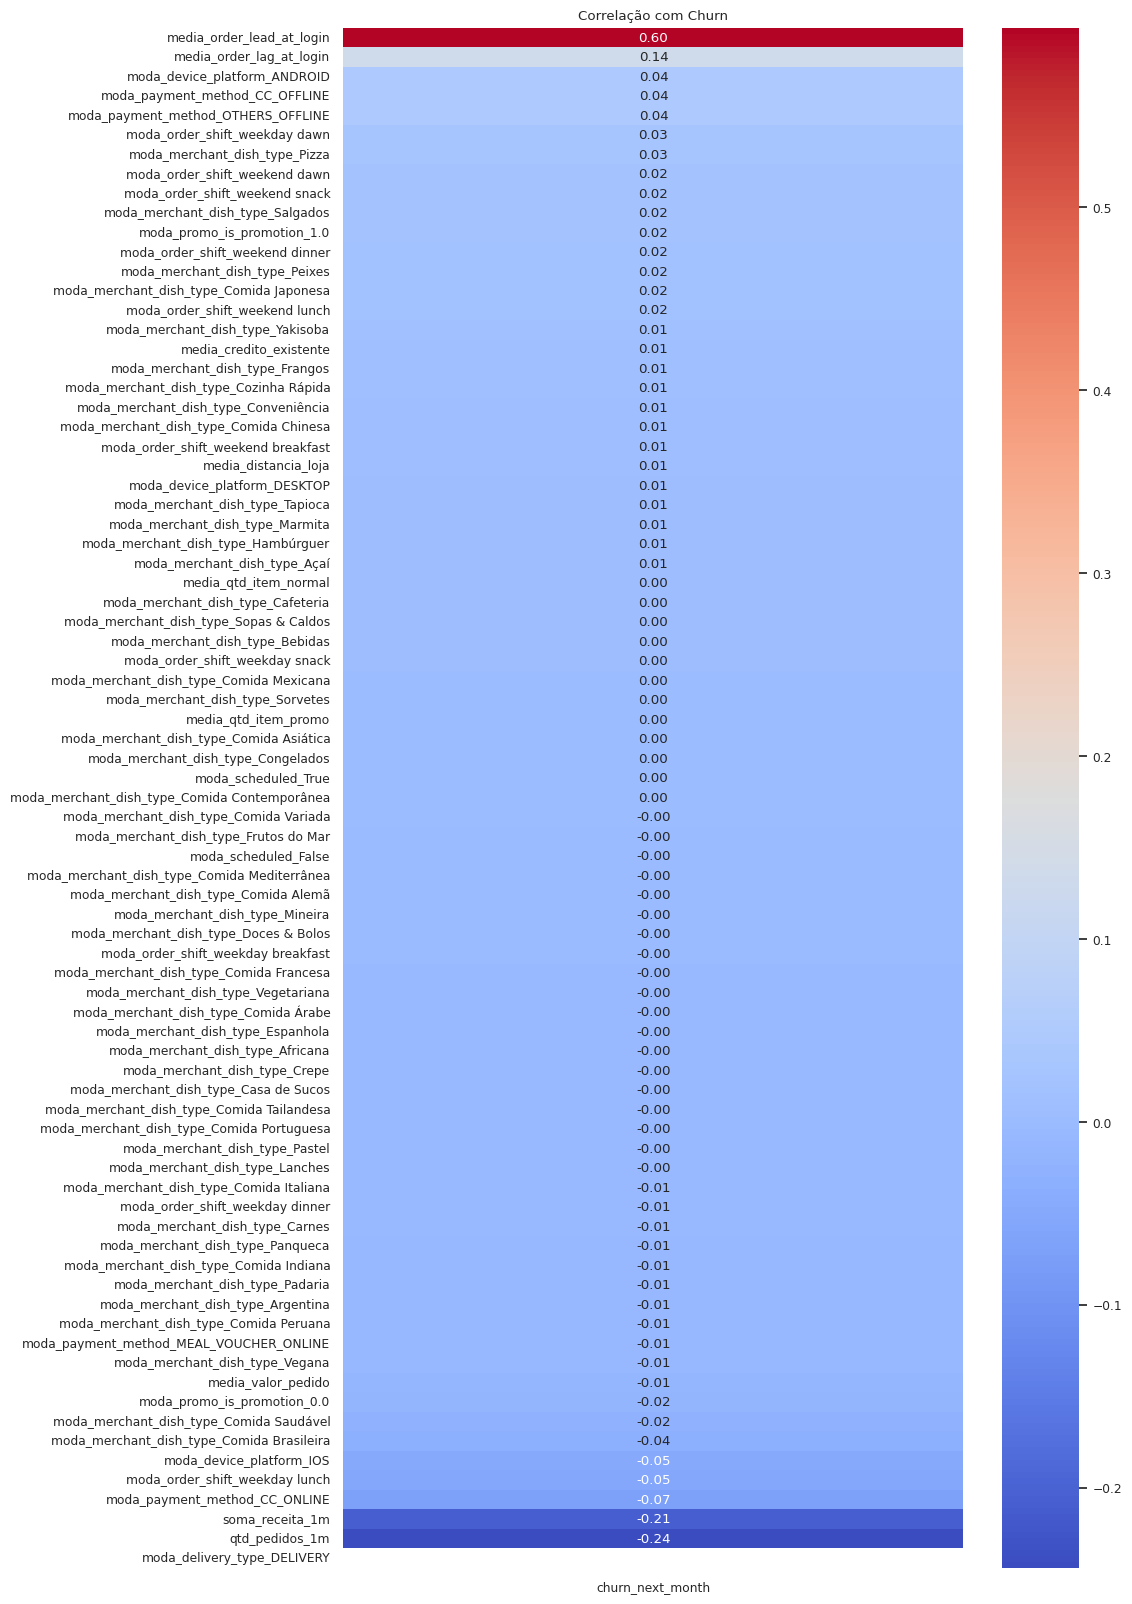

In [174]:
corr = list_encoded_abts[0].corr()
target_corr = corr[lbl_y].drop(lbl_y)

target_corr_sorted = target_corr.sort_values(ascending=False)

fig, ax = plt.subplots(figsize=(10,20))
sns.set(font_scale=0.8)
sns.set_style("white")
sns.set_palette("PuBuGn_d")
sns.heatmap(target_corr_sorted.to_frame(), cmap="coolwarm", annot=True, fmt='.2f', ax=ax)
plt.title('Correlação com Churn')
plt.show()

# MODELAGEM

Para o treino d modelo vamos considerar as features `'media_order_lead_at_login', 'media_order_lag_at_login', 'soma_receita_1m', 'qtd_pedidos_1m'` dado que possuem valores de IV e Correlação mais relevantes bem como indicativos da capacidade de separação na variável target como visto nos plots dos gráficos.

In [188]:
feature_cols = ['media_order_lead_at_login', 'media_order_lag_at_login', 'soma_receita_1m', 'qtd_pedidos_1m', 'media_qtd_item_normal', 'media_qtd_item_promo', 'media_credito_existente']

In [189]:
train_month_7 = list_encoded_abts[0].copy()
oot_month_8 = list_encoded_oots[0].copy()

In [190]:
X_train = train_month_7[feature_cols]
X_oot = oot_month_8[feature_cols]

y_train = train_month_7[lbl_y]
y_oot = oot_month_8[lbl_y]

## Random Forest

In [191]:
rf = RandomForestClassifier(random_state=42)
rf_model = rf.fit(X=X_train, y=y_train)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(estimator=rf_model, X=X_train, y=y_train, scoring='roc_auc', cv=skf)

print('Média dos AUC na base de treino: '+str(cv_results.mean())+'\n')

oot_month_8['y_pred'] = rf_model.predict(X_oot)
oot_month_8['y_proba'] = rf_model.predict_proba(X_oot)[:, 1]

auc = metrics.roc_auc_score(y_oot, oot_month_8['y_pred'])

print('Probabilidades para Y = 1')
print(oot_month_8[['churn_next_month','y_pred','y_proba']].head().to_string())

print('\nAUC na OOT: '+str(auc))

Média dos AUC na base de treino: 0.9557217663238887

Probabilidades para Y = 1
   churn_next_month  y_pred  y_proba
0                 0       0     0.16
1                 0       0     0.32
2                 0       0     0.37
3                 0       0     0.30
4                 0       0     0.49

AUC na OOT: 0.8522681400541737


## LGBM

In [192]:
lgbm = LGBMClassifier(random_state=42, verbose=-1)

lgbm_model = lgbm.fit(X=X_train, y=y_train)

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_results = cross_val_score(estimator=lgbm_model, X=X_train, y=y_train, scoring='roc_auc', cv=skf)

print('Média dos AUC na base de treino: '+str(cv_results.mean())+'\n')

oot_month_8['y_pred'] = lgbm_model.predict(X_oot)
oot_month_8['y_proba'] = lgbm_model.predict_proba(X_oot)[:, 1]

auc = metrics.roc_auc_score(y_oot, oot_month_8['y_pred'])

print('Probabilidades para Y = 1')
print(oot_month_8[['churn_next_month','y_pred','y_proba']].head().to_string())

print('\nAUC na OOT: '+str(auc))

Média dos AUC na base de treino: 0.9604208693456476

Probabilidades para Y = 1
   churn_next_month  y_pred   y_proba
0                 0       0  0.053548
1                 0       0  0.074101
2                 0       0  0.205388
3                 0       0  0.061763
4                 0       0  0.067288

AUC na OOT: 0.874733222613653


In [193]:
parameters = {'max_depth': [3, 5, 7, 9],
'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
'n_estimators': [100, 300, 500],
'random_state': [42]}

grid_search = GridSearchCV(lgbm, parameters, scoring='roc_auc', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

# Recupere o melhor AUC
print('AUC do melhor modelo:')
print(results[results.rank_test_score==1].mean_test_score.item())
# Recupere os hiperparâmetros
print('\nHiperparâmetros:')
print(results[results.rank_test_score==1].params.item())

# Crie a variável best_model e salve o melhor estimador do grid_search nessa variável
best_model = grid_search.best_estimator_

# Avalei o desempenho do melhor modelo no grid search na base OOT
oot_month_8['y_pred'] = best_model.predict(X_oot)
oot_month_8['y_proba'] = best_model.predict_proba(X_oot)[:, 1]

auc = metrics.roc_auc_score(y_oot, oot_month_8['y_pred'])

print('\nProbabilidades para Y = 1')
print(oot_month_8[['churn_next_month','y_pred', 'y_proba']].head().to_string())

print('\nAUC na OOT: '+str(auc))

AUC do melhor modelo:
0.960385059810249

Hiperparâmetros:
{'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'random_state': 42}

Probabilidades para Y = 1
   churn_next_month  y_pred   y_proba
0                 0       0  0.038936
1                 0       0  0.058764
2                 0       0  0.181301
3                 0       0  0.066658
4                 0       0  0.036552

AUC na OOT: 0.8744716978632605


# TESTANDO EM OUTRAS SAFRAS

In [194]:
for data in list_encoded_oots:

  #Encoding
  encoded_df_oot = data.copy()

  X_oot = encoded_df_oot[feature_cols].copy()
  y_oot = encoded_df_oot[lbl_y].copy()

  encoded_df_oot['y_pred'] = best_model.predict(X_oot)
  encoded_df_oot['y_proba'] = best_model.predict_proba(X_oot)[:, 1]
  auc = metrics.roc_auc_score(y_oot, encoded_df_oot['y_pred'])

  print('AUC na OOT: '+str(auc))

AUC na OOT: 0.8744716978632605
AUC na OOT: 0.8626439958397403
AUC na OOT: 0.829670410037217
AUC na OOT: 0.7736493221690589
AUC na OOT: 0.7151417329117539


# TREINO E TESTE PARA CADA SAFRA

In [195]:
i=0
for abt in list_encoded_abts:

  #Training Model
  X_train = abt[feature_cols].copy()
  y_train = abt[lbl_y].copy()

  lgbm = LGBMClassifier(random_state=42, verbose=-1)
  lgbm_model = lgbm.fit(X=X_train, y=y_train)

  #Predicting
  encoded_df_oot = list_encoded_oots[i].copy()

  X_oot = encoded_df_oot[feature_cols].copy()
  y_oot = encoded_df_oot[lbl_y].copy()

  encoded_df_oot['y_pred'] = lgbm_model.predict(X_oot)
  encoded_df_oot['y_proba'] = lgbm_model.predict_proba(X_oot)[:, 1]
  auc = metrics.roc_auc_score(y_oot, encoded_df_oot['y_pred'])

  print('AUC na OOT: '+str(auc))

  i+=1

AUC na OOT: 0.874733222613653
AUC na OOT: 0.8923991119099417
AUC na OOT: 0.8675844289870147
AUC na OOT: 0.8560107655502392
AUC na OOT: 0.8108456622993929


# AMOSTRA COM 5 MESES

In [196]:
i=0
for data in list_encoded_abts:

  if i != 0:
    df_train_final = pd.concat([df_train_final, data], axis = 0)
  else:
    df_train_final = data

  i+=1

#Training Model
X_train = df_train_final[feature_cols].copy()
y_train = df_train_final[lbl_y].copy()
lgbm = LGBMClassifier(random_state=42, verbose=-1)

parameters = {'max_depth': [3, 5, 7, 9],
'learning_rate': [0.01, 0.015, 0.025, 0.05, 0.1],
'n_estimators': [100, 300, 500]}

grid_search = GridSearchCV(lgbm, parameters, scoring='roc_auc', cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)

# Crie a variável best_model e salve o melhor estimador do grid_search nessa variável
best_model = grid_search.best_estimator_

#Predicting
encoded_df_oot = list_encoded_oots[-1].copy()

X_oot = encoded_df_oot[feature_cols].copy()
y_oot = encoded_df_oot[lbl_y].copy()

encoded_df_oot['y_pred'] = best_model.predict(X_oot)
encoded_df_oot['y_proba'] = best_model.predict_proba(X_oot)[:, 1]
auc = metrics.roc_auc_score(y_oot, encoded_df_oot['y_pred'])

print('AUC na OOT: '+str(auc))

AUC na OOT: 0.8076019745330761


# SHAP

In [197]:
pip install shap

In [198]:
import shap
explainer = shap.TreeExplainer(best_model)

In [199]:
shap_values = explainer.shap_values(X_oot)

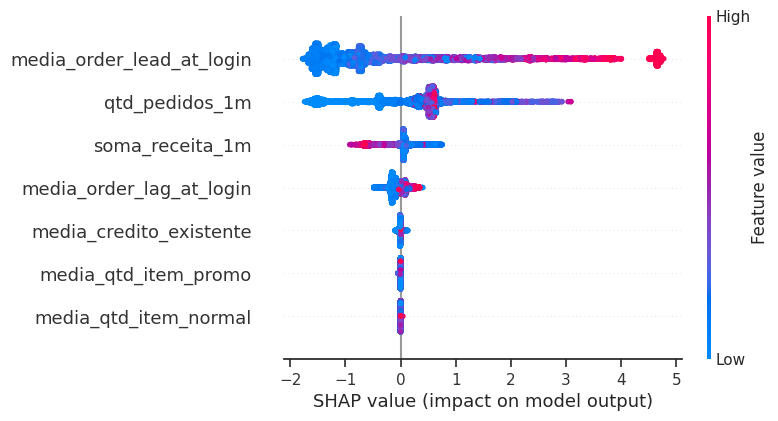

In [200]:
shap.summary_plot(shap_values[1], X_oot, plot_type='dot')

# CONCLUSÃO

O objetivo proposto de identificar a probabilidade de churn de um cliente na plataforma foi satisfeito com o modelo proposto. Temos AUC que gira em torno de 80% ~ 90% indicando grande capacidade de diferenciação entre os grupos.

A variável `media_order_lead_at_login` foi identificada como feature com mais relevância conforme shap values do modelo, análise exploratória e correlações calculadas. Esta variável representa a quantidade de dias entre os pedidos.

Valores extremos desta feature impactam significativamente nas chances de Churn, portanto manter o cliente utilizando o app ou seja com promoções, cupons e notificações podem ser estratégias benéficas.

Como esperado de `qtd_pedidos_1m`, clientes com mais pedidos podem retornar e clientes que não fazem muitos pedidos podem ser churn no proximo período. Talvez uma estratégia de cupons ou descontos pode encorajar o cliente a realizar mais pedidos.

`soma_receita_1m` indica que clientes que gastam mais tem menores probabilidade de Churn do que clientes que gastam valores mais elevados, que está em linha com a tendência de Churn estar atrelado a capacidade financeira dos clientes.

O presente projeto buscou explorar as características de comportamento dos clientes visando a probabilidade de Churn. As features mais significativas foram exatamente relacionadas a realização dos pedidos, portanto há alta correlação entre clientes que pedem muito e vão voltar a pedir. Para estudos futuros seria interessante integrar modelos de segmentação de clientes para a predição.